# Models Evaluation (Adaboost & XGBoost)

## Notebook Configuration

### Imports

In [2]:
#Standard
import pandas as pd
import numpy as np 
import time 
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.lib.deepreload import reload as dreload
#ML
#from eml.model_eval import classifier_metrics, get_classification_report, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, StandardScaler
#Settings
pd.set_option("display.max_columns", 200, "display.max_rows", 200)
%load_ext autoreload
%autoreload 2
%matplotlib inline
sns.set()

### Data

In [3]:
df_modified = pd.read_csv(r'C:\Users\Antoine\Coding Bootcamp\Open Food Facts\data_training_names.csv', low_memory=False)

In [31]:
def duplicates_pnns(df): 
    def other_pnns(row): return row['pnns_groups_3']
    copy_loc = df.loc[df['pnns_groups_2'] != df['pnns_groups_3']].copy(deep=True)
    copy_loc['pnns_groups_2'] = copy_loc.apply(lambda row: other_pnns(row=row), axis=1)
    df = df.append(copy_loc)
    return df

In [32]:
%%time
df = duplicates_pnns(df_modified)

Wall time: 5.36 s


In [45]:
#Features & Target
features = df_modified.drop(columns=['pnns_groups_1', 'pnns_groups_2', 'pnns_groups_3', 'pnns_groups_4', 'code', 'url', 'ingredients', 'product_name'])
target = df_modified[['pnns_groups_1', 'pnns_groups_2', 'pnns_groups_3']]
#Label Encoding
le = LabelEncoder()
le.fit(target['pnns_groups_1'])
encoded_target_1 = le.transform(target['pnns_groups_1']).reshape(-1,1)
le_2 = LabelEncoder()
le_2.fit(target['pnns_groups_2'])
encoded_target_2 = le_2.transform(target['pnns_groups_2']).reshape(-1,1)
le_2.fit(target['pnns_groups_3'])
encoded_target_3 = le_2.transform(target['pnns_groups_3']).reshape(-1,1)
encoded_target = np.append(encoded_target_1, encoded_target_2, axis=1)
encoded_target = np.append(encoded_target, encoded_target_3, axis=1)
#Train test split
X_train, X_test, y_train_full, y_test_full = train_test_split(features, encoded_target, test_size=0.2, random_state=42, stratify=encoded_target[:,:2])

In [46]:
y_train = y_train_full[:,:2]
y_test = y_test_full[:,:2]

### Custom Metrics Functions

We define some custom function to get new relevant metrics for models evaluation & comparaison.

- $scoringsets$ : Evaluate the proportion of equals sets instead of individual group predictions.
    Classic metrics compare a single $ypred$ vector with a single $ytrue$ vector.
    This function add the information of how many sets are correctly predicted, to evaluate both $({G_1, G_2})$ and $({G_2, G_3})$.
    
- $ensemblesimilarity$ : Evaluate the proportion of single predictions that are at least members in the true set.
    Because $ytrue$ for $G_2$ can take multiple values (this is denoted as $G_3$), we want to know if the prediction is correct for $G_2$ * **or * $G_3$. If $ypred = A$ and $ytrue = (A,B)$, the prediction is considered as correct.

- custom_metrics : $scoringsets$ and $ensemblesimilarity$ concatened in one function.
    

In [5]:
def scorings_sets(y_true, y_pred):
    scores = []
    for i, y in enumerate(y_pred):
        if set(y) == set(y_true[i,:]): scores.append(1)
        else: scores.append(0)
    return round(np.array(scores).mean()*100,2)

In [6]:
def ensemble_similarity(y_true, y_pred):
    scores = []
    for i,y in enumerate(y_pred):
        if y in y_true[i,:] : scores.append(1)
        else: scores.append(0)
    return round(np.array(scores).mean()*100,2)

In [7]:
def custom_metrics(y_true, y_pred, score_type='nb_sets_equal'):
    scores = []
    for i,y in enumerate(y_pred):
        if score_type == 'nb_preds_in_sets':
            if y in y_true[i,:] : scores.append(1)
            else: scores.append(0)
        if score_type == 'nb_sets_equal':
            if set(y) == set(y_true[i,:]): scores.append(1)
            else: scores.append(0)
    return round(np.array(scores).mean()*100,2)

## Adaboost

### Load model

In [12]:
import pickle
pkl_filename = "adaboost.pkl"
with open(pkl_filename, 'rb') as file:
    adaboost = pickle.load(file)

C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator AdaBoostClassifier from version 0.24.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator ClassifierChain from version 0.24.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


### Global metrics

In [13]:
y_preds_train = adaboost.predict(X_train)
y_preds_test = adaboost.predict(X_test)
classifier_metrics(y_test=y_train[:,0], y_preds=y_preds_train[:,0], average='macro', model='Train Set Class1 - Adaboost')
classifier_metrics(y_test=y_test[:,0], y_preds=y_preds_test[:,0], average='macro', model='Test Set Class1 - Adaboost')
classifier_metrics(y_test=y_train[:,1], y_preds=y_preds_train[:,1], average='macro', model='Train Set Class2 - Adaboost')
classifier_metrics(y_test=y_test[:,1], y_preds=y_preds_test[:,1], average='macro', model='Test Set Class2 - Adaboost')

Train Set Class1 - Adaboost Classification Metrics :
-------------------
Accuracy : 94.16%
Recall : 93.71%
Precision : 94.00%
F1-score : 93.67%


Test Set Class1 - Adaboost Classification Metrics :
-------------------
Accuracy : 83.34%
Recall : 81.63%
Precision : 83.11%
F1-score : 82.11%


Train Set Class2 - Adaboost Classification Metrics :
-------------------
Accuracy : 91.77%
Recall : 88.63%
Precision : 91.04%
F1-score : 89.50%


Test Set Class2 - Adaboost Classification Metrics :
-------------------
Accuracy : 76.67%
Recall : 69.39%
Precision : 77.61%
F1-score : 72.61%




### Classification reports

In [19]:
report_1 = get_classification_report(y_test=le.inverse_transform(y_test[:,0]), y_pred=le.inverse_transform(y_preds_test[:,0].astype(int)), model='Test_1_Adaboost', sortby='precision')
report_2 = get_classification_report(y_test=le_2.inverse_transform(y_test[:,1]), y_pred=le_2.inverse_transform(y_preds_test[:,1].astype(int)), model='Test_2_Adaboost', sortby='precision')

In [25]:
report_2

Test_2_Adaboost_precision  \
pizza pies and quiche                                  0.97   
sandwiches                                             0.96   
eggs                                                   0.95   
pastries                                               0.94   
cheese                                                 0.93   
dressings and sauces                                   0.91   
ice cream                                              0.91   
salty and fatty products                               0.88   
fats                                                   0.88   
milk and yogurt                                        0.88   
chocolate products                                     0.87   
fish and seafood                                       0.85   
sweets                                                 0.84   
offals                                                 0.84   
plant based milk substitutes                           0.84   
processed meat                                         0.84   
appetizers                                             0.83   
nuts                                                   0.82   
potatoes                                               0.81   
bread                                                  0.81   
breakfast cereals                                      0.81   
fruit juices                                           0.79   
weighted avg                                           0.78   
macro avg                                              0.78   
dairy desserts                                         0.77   
accuracy                                               0.77   
biscuits and cakes                                     0.76   
soups                                                  0.76   
sweetened beverages                                    0.75   
fruits                                                 0.75   
cereals                                                0.74   
waters and flavored waters                             0.73   
one dish meals                                         0.67   
artificially sweetened beverages                       0.66   
meat                                                   0.65   
legumes                                                0.64   
dried fruits                                           0.60   
teas and herbal teas and coffees                       0.57   
vegetables                                             0.48   
fruit nectars                                          0.41   
unsweetened beverages                                  0.38   

                                  Test_2_Adaboost_recall  \
pizza pies and quiche                               0.66   
sandwiches                                          0.60   
eggs                                                0.83   
pastries                                            0.63   
cheese                                              0.88   
dressings and sauces                                0.78   
ice cream                                           0.71   
salty and fatty products                            0.80   
fats                                                0.80   
milk and yogurt                                     0.82   
chocolate products                                  0.82   
fish and seafood                                    0.77   
sweets                                              0.83   
offals                                              0.55   
plant based milk substitutes                        0.80   
processed meat                                      0.90   
appetizers                                          0.71   
nuts                                                0.67   
potatoes                                            0.66   
bread                                               0.81   
breakfast cereals                                   0.67   
fruit juices                                        0.77   
weighte

Text(0.5, 1.0, 'Adaboost Class 1 Precision by category')

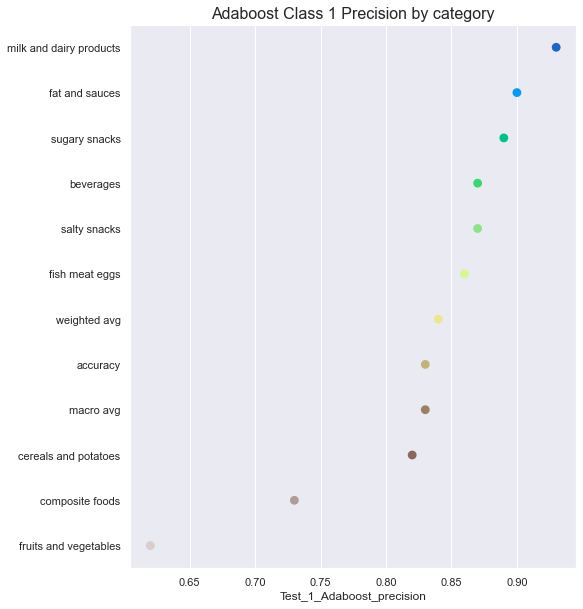

In [20]:
plt.figure(figsize=(8,10))
sns.pointplot(y=report_1.index, x=report_1['Test_1_Adaboost_precision'], palette='terrain', size=report_1['Test_1_Adaboost_support'])
plt.title('Adaboost Class 1 Precision by category', fontsize=16)

Text(0.5, 1.0, 'Adaboost Class 2 Precision by category')

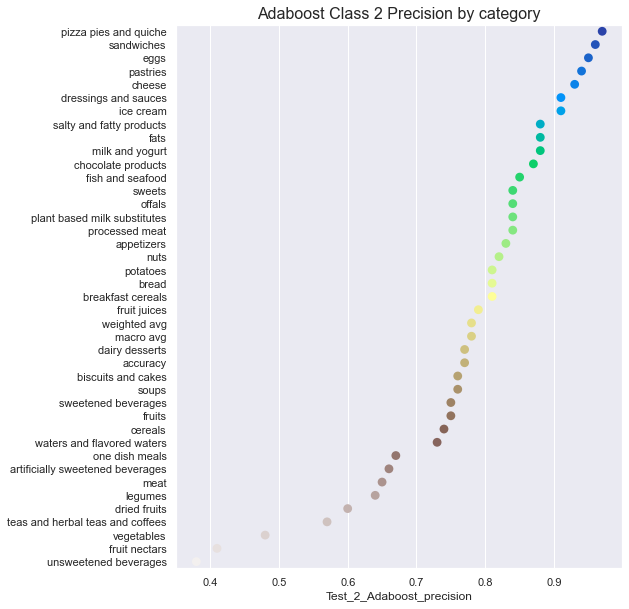

In [21]:
plt.figure(figsize=(8,10))
sns.pointplot(y=report_2.index, x=report_2['Test_2_Adaboost_precision'], palette='terrain', size=report_2['Test_2_Adaboost_support'])
plt.title('Adaboost Class 2 Precision by category', fontsize=16)

### How many items are correctly classified for both group 1 and group 2 ?

In [23]:
scorings_sets(y_test, y_preds_test)

76.64

### How many items predicted are in group 2 or group 3 ?

In [24]:
ensemble_similarity(y_test_full[:,1:], y_preds_test[:,1])

78.89

## XGBoost

### Load Model

In [17]:
import xgboost as xgb
from xgboost import XGBClassifier
xgb_model_group_1 = XGBClassifier()
xgb_model_group_1.load_model("xgboost_group1.model")
xgb_model_group_2 = XGBClassifier()
xgb_model_group_2.load_model("xgboost_group2.model")

In [28]:
pnns_1_preds_test = xgb_model_group_1.predict(X_test)
X_test_withpred = np.append(X_test, pnns_1_preds_test.reshape(-1,1), axis=1)

In [30]:
y_preds_test = xgb_model_group_2.predict(X_test_withpred)

In [33]:
y_preds_test = np.append(pnns_1_preds_test.reshape(-1,1), y_preds_test.reshape(-1,1), axis=1)
y_preds_test

array([[ 8,  7],
       [ 2, 23],
       [ 6, 20],
       ...,
       [ 6, 20],
       [ 4, 28],
       [ 8,  7]], dtype=int64)

### Global Metrics

In [34]:
classifier_metrics(y_test=y_test[:,0], y_preds=y_preds_test[:,0], average='macro', model='Test Set Class1 - XGBoost')
classifier_metrics(y_test=y_test[:,1], y_preds=y_preds_test[:,1], average='macro', model='Test Set Class2 - XGBoost')

Test Set Class1 - XGBoost Classification Metrics :
-------------------
Accuracy : 88.96%
Recall : 87.73%
Precision : 88.97%
F1-score : 88.19%


Test Set Class2 - XGBoost Classification Metrics :
-------------------
Accuracy : 85.74%
Recall : 82.56%
Precision : 86.09%
F1-score : 84.05%




### How many items are correctly classified for both group 1 and group 2 ?

In [39]:
scorings_sets(y_test, y_preds_test)

84.52

### How many items predicted are in group 2 or group 3 ?

In [40]:
ensemble_similarity(y_test_full[:,1:], y_preds_test[:,1])

86.95

### Confusion Matrix

In [112]:
cm_1 = metrics.confusion_matrix(le.inverse_transform(y_test[:,0]), le.inverse_transform(y_preds_test[:,0].astype(int)))
cm_2 = metrics.confusion_matrix(le_2.inverse_transform(y_test[:,1]), le_2.inverse_transform(y_preds_test[:,1].astype(int)))

Text(0.5, 1.0, 'XGBoost G1 Confusion Matrix')

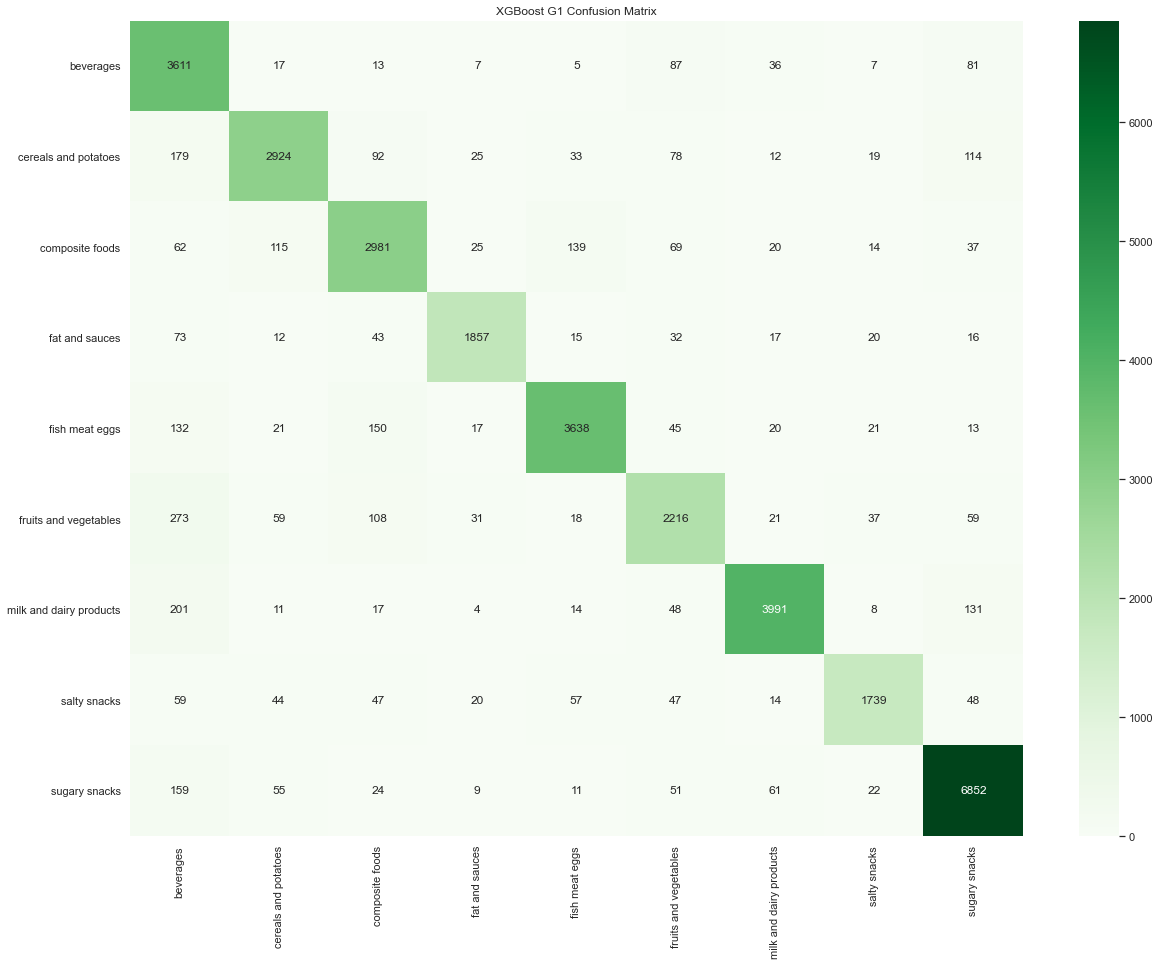

In [120]:
plt.figure(figsize=(20,15))
heatmap = sns.heatmap(cm_1, vmin=0, xticklabels=le.classes_, yticklabels=le.classes_,annot=True, cmap='Greens', fmt='g')
heatmap.set_title("XGBoost G1 Confusion Matrix")

Text(0.5, 1.0, 'XGBoost G2 Confusion Matrix')

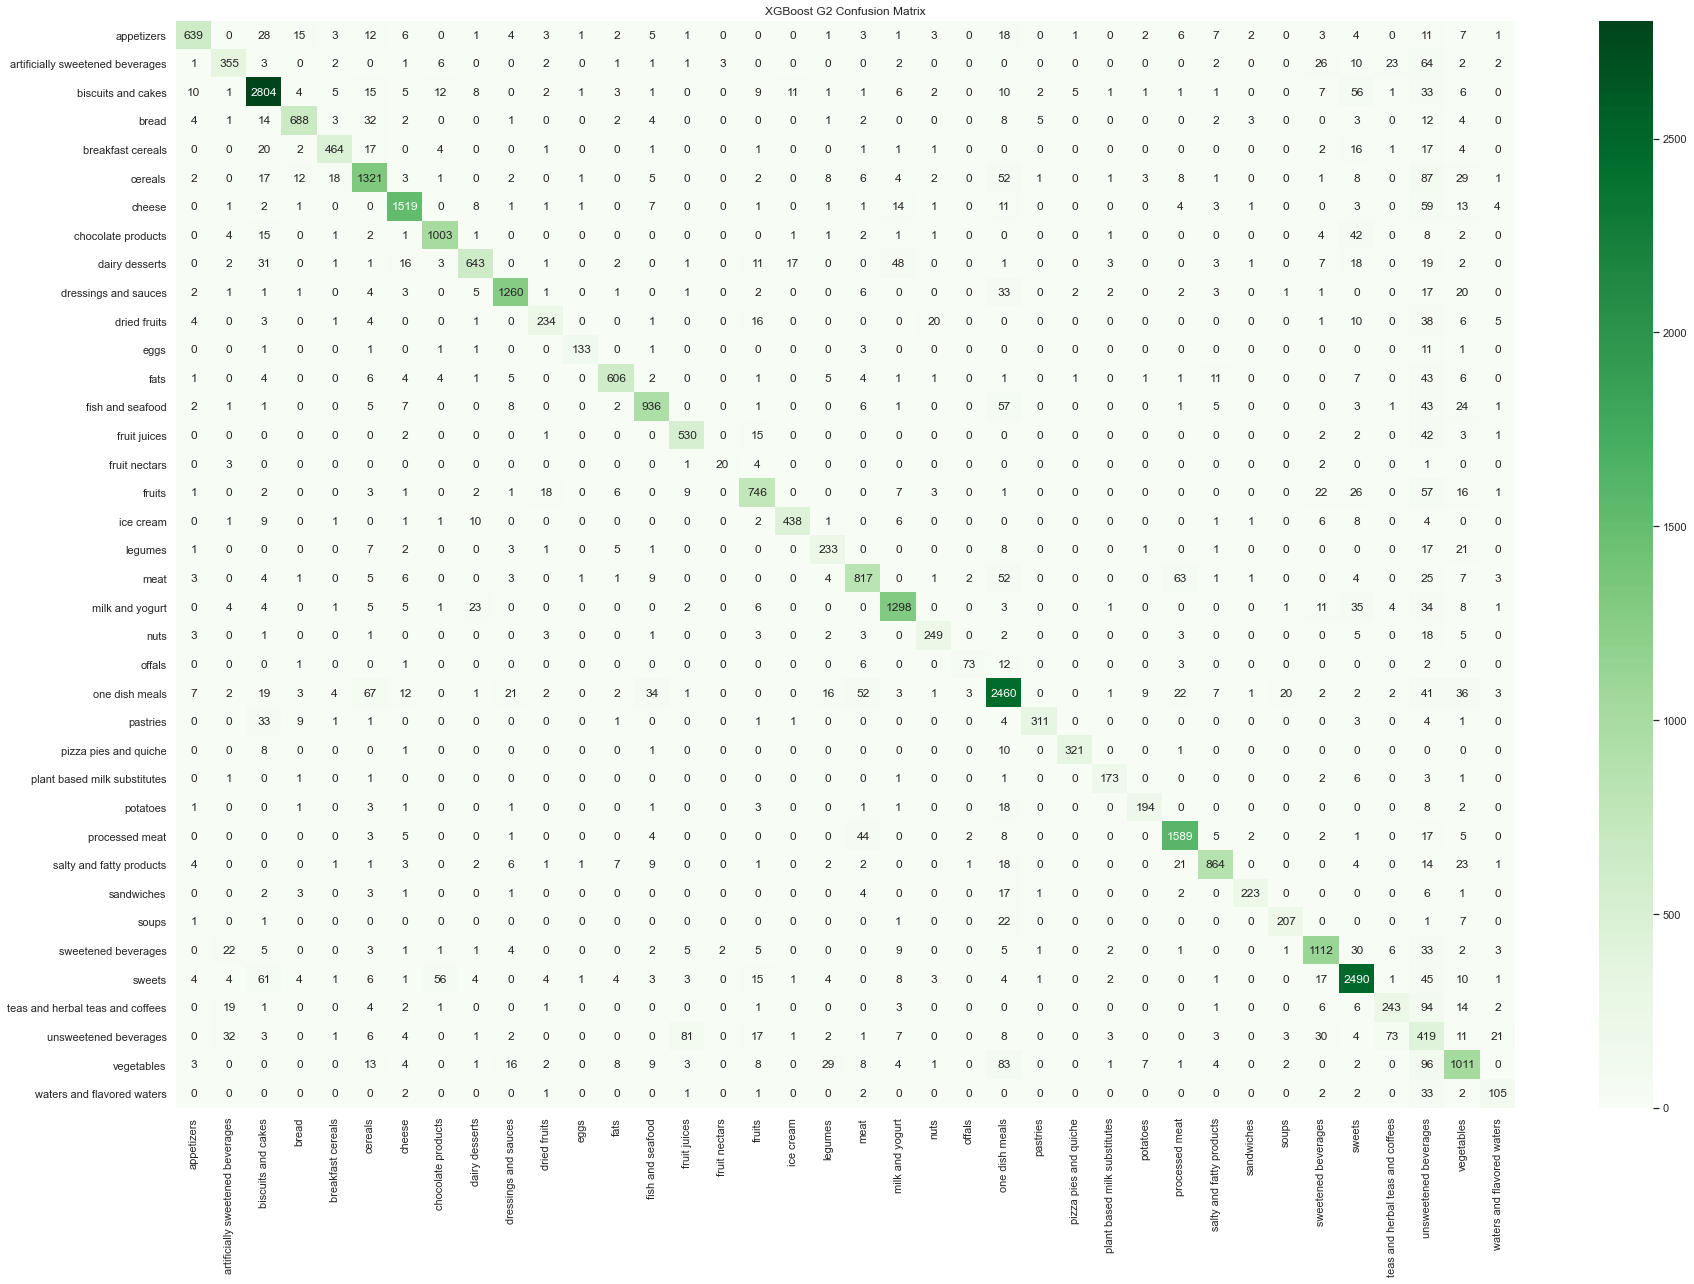

In [119]:
plt.figure(figsize=(30,20))
heatmap = sns.heatmap(cm, vmin=0, xticklabels=le_2.classes_, yticklabels=le_2.classes_,annot=True, cmap='Greens', fmt='g')
heatmap.set_title("XGBoost G2 Confusion Matrix")

### Classification reports

In [35]:
report_1 = get_classification_report(y_test=le.inverse_transform(y_test[:,0]), y_pred=le.inverse_transform(y_preds_test[:,0].astype(int)), model='Test_1_XGBoost', sortby='precision')
report_2 = get_classification_report(y_test=le_2.inverse_transform(y_test[:,1]), y_pred=le_2.inverse_transform(y_preds_test[:,1].astype(int)), model='Test_2_XGBoost', sortby='precision')

In [103]:
report_1

Test_1_XGBoost_precision  Test_1_XGBoost_recall  \
milk and dairy products                      0.95                   0.90   
sugary snacks                                0.93                   0.95   
fat and sauces                               0.93                   0.89   
fish meat eggs                               0.93                   0.90   
salty snacks                                 0.92                   0.84   
cereals and potatoes                         0.90                   0.84   
weighted avg                                 0.89                   0.89   
macro avg                                    0.89                   0.88   
accuracy                                     0.89                   0.89   
composite foods                              0.86                   0.86   
fruits and vegetables                        0.83                   0.79   
beverages                                    0.76                   0.93   

                         Test_1_XGBoost_f1-score  Test_1_XGBoost_support  
milk and dairy products                     0.93                 4425.00  
sugary snacks                               0.94                 7244.00  
fat and sauces                              0.91                 2085.00  
fish meat eggs                              0.91                 4057.00  
salty snacks                                0.88                 2075.00  
cereals and potatoes                        0.87                 3476.00  
weighted avg                                0.89                33510.00  
macro avg                                   0.88                33510.00  
accuracy                                    0.89                    0.89  
composite foods                             0.86                 3462.00  
fruits and vegetables                       0.81                 2822.00  
beverages                                   0.84                 3864.00

In [108]:
report_2

Test_2_XGBoost_precision  \
pizza pies and quiche                                 0.97   
pastries                                              0.97   
eggs                                                  0.95   
sandwiches                                            0.95   
dressings and sauces                                  0.94   
cheese                                                0.94   
salty and fatty products                              0.93   
ice cream                                             0.93   
fats                                                  0.93   
bread                                                 0.92   
appetizers                                            0.92   
processed meat                                        0.92   
chocolate products                                    0.92   
breakfast cereals                                     0.91   
milk and yogurt                                       0.91   
plant based milk substitutes                          0.91   
biscuits and cakes                                    0.91   
fish and seafood                                      0.90   
offals                                                0.90   
dairy desserts                                        0.90   
potatoes                                              0.89   
sweets                                                0.89   
soups                                                 0.88   
sweetened beverages                                   0.88   
weighted avg                                          0.87   
nuts                                                  0.86   
macro avg                                             0.86   
accuracy                                              0.86   
fruits                                                0.86   
cereals                                               0.85   
one dish meals                                        0.84   
dried fruits                                          0.84   
meat                                                  0.84   
fruit juices                                          0.83   
fruit nectars                                         0.80   
artificially sweetened beverages                      0.78   
vegetables                                            0.77   
legumes                                               0.75   
teas and herbal teas and coffees                      0.68   
waters and flavored waters                            0.67   
unsweetened beverages                                 0.28   

                                  Test_2_XGBoost_recall  \
pizza pies and quiche                              0.94   
pastries                                           0.84   
eggs                                               0.87   
sandwiches                                         0.84   
dressings and sauces                               0.92   
cheese                                             0.92   
salty and fatty products                           0.88   
ice cream                                          0.89   
fats                                               0.85   
bread                                              0.87   
appetizers                                         0.81   
processed meat                                     0.94   
chocolate products                                 0.92   
breakfast cereals                                  0.84   
milk and yogurt                                    0.90   
plant based milk substitutes                       0.91   
biscuits and cakes                                 0.93   
fish and seafood                                   0.85   
offals                                             0.74   
dairy desserts                                     0.77   
potatoes                                           0.83   
sweets                                             0.90   
soups                                              0.86   
sweetened bev

Text(0.5, 1.0, 'XGBoost Class 1 Precision by category')

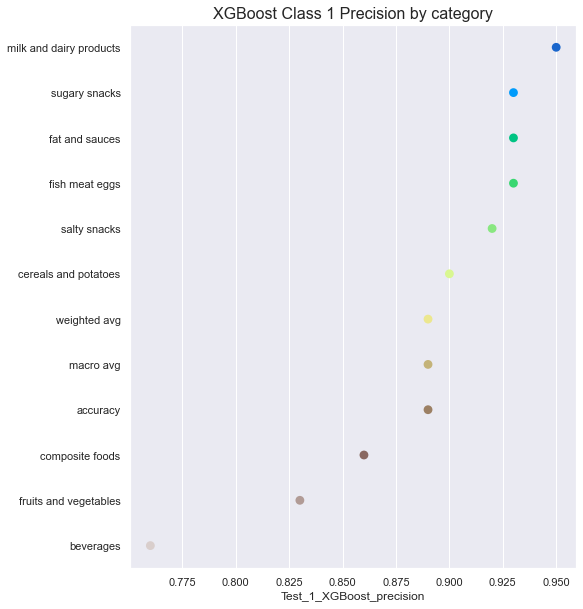

In [36]:
plt.figure(figsize=(8,10))
sns.pointplot(y=report_1.index, x=report_1['Test_1_XGBoost_precision'], palette='terrain', size=report_1['Test_1_XGBoost_support'])
plt.title('XGBoost Class 1 Precision by category', fontsize=16)

Text(0.5, 1.0, 'XGBoost Class 2 Precision by category')

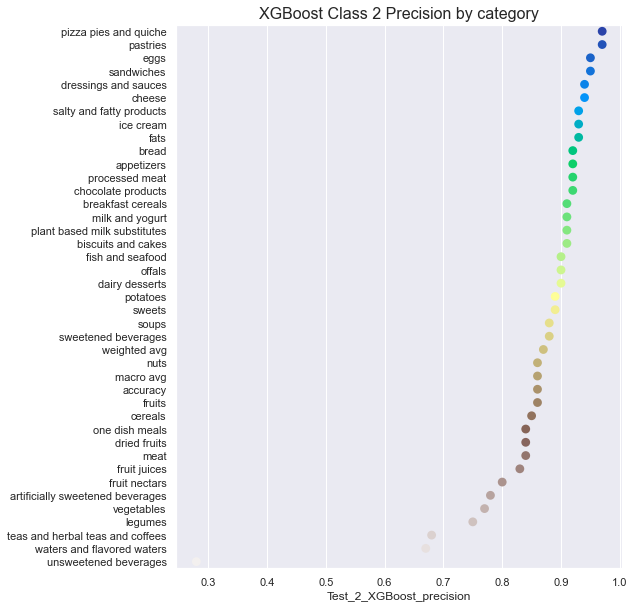

In [38]:
plt.figure(figsize=(8,10))
sns.pointplot(y=report_2.index, x=report_2['Test_2_XGBoost_precision'], palette='terrain', size=report_2['Test_2_XGBoost_support'])
plt.title('XGBoost Class 2 Precision by category', fontsize=16)

### Confidence level graphics

In [79]:
def get_df_predictions(model, X, y, label_encoder):
    preds = model.predict(X)
    preds_probas = model.predict_proba(X)
    probas = []
    for index, label in enumerate(preds):
        probas.append(preds_probas[index,label])
    data = pd.DataFrame({'true_label':label_encoder.inverse_transform(y),'pred':label_encoder.inverse_transform(preds.astype(int)), 'proba':probas})
    data['pred_is_true'] = data.apply(lambda x: 1 if x['true_label'] == x['pred'] else 0, axis=1)
    return data

In [94]:
def plot_confidence(model, X, y, label_encoder, name='model', metric='precision', col_wrap=5):
    data = get_df_predictions(model=model, X=X, y=y, label_encoder=label_encoder)
    report = get_classification_report(y_test=data['true_label'], y_pred=data['pred'], model=name, sortby=metric)
    hue_palette = {0:'darkred', 1:'darkgreen'}
    labels = data.true_label.unique()
    g = sns.FacetGrid(data, col='true_label', hue="pred_is_true", col_wrap=col_wrap, height=5,palette=hue_palette, xlim=(0,1))
    g.map(sns.kdeplot, 'proba', fill=True, common_norm=True, alpha=.4)
    g.add_legend()
    for ax, label in zip(g.axes.flat, labels):
        ax.set_title(f'{label} | {metric} : {report[f"{name}_{metric}"][label]}')

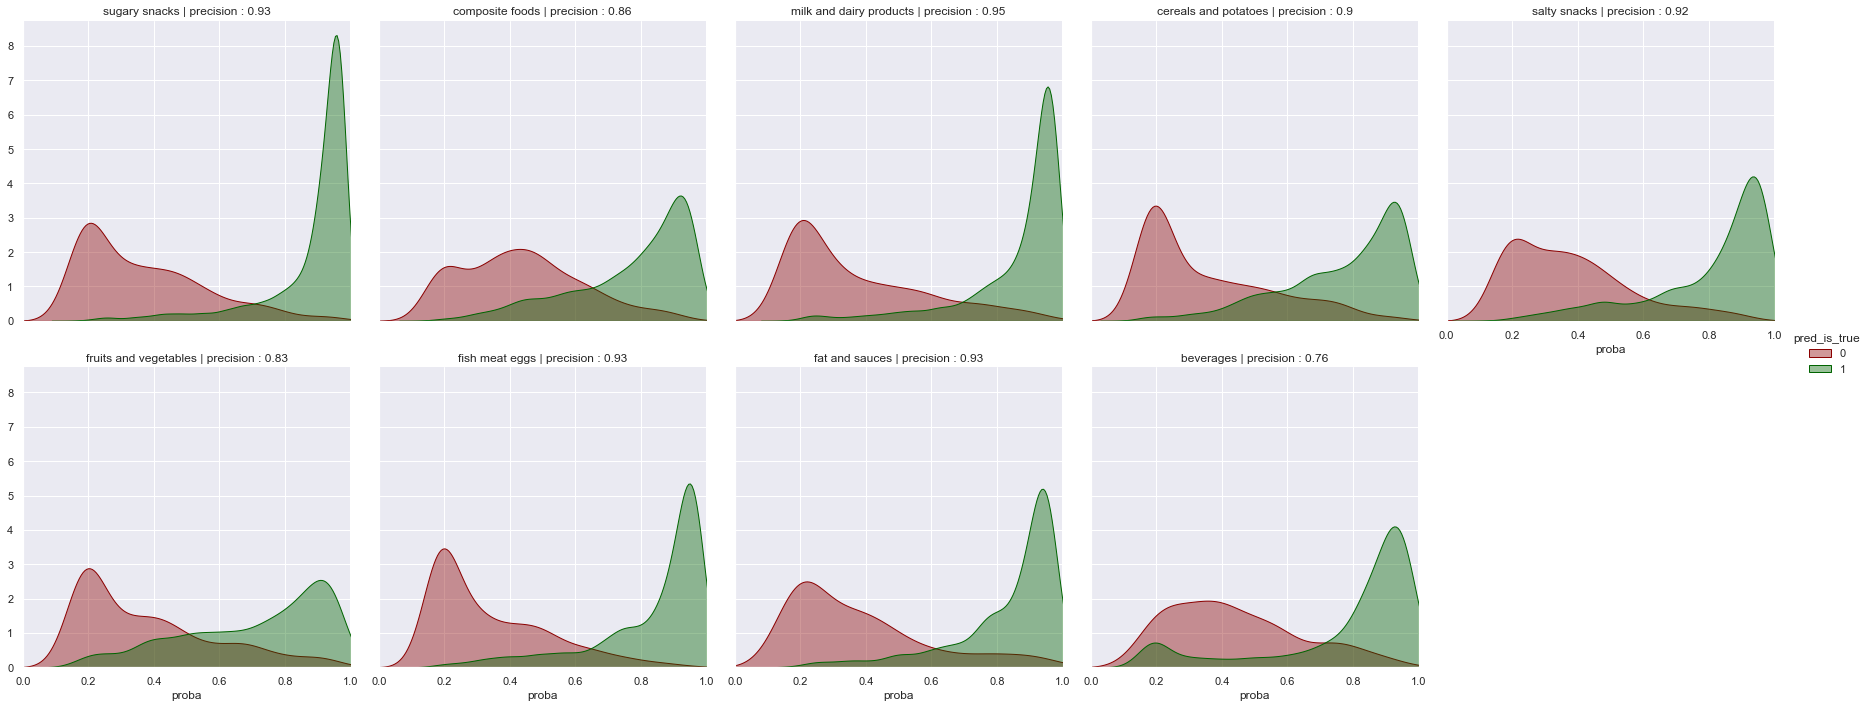

In [95]:
plot_confidence(model=xgb_model_group_1, X=X_test, y=y_test[:,0], label_encoder=le, name='xgboost')

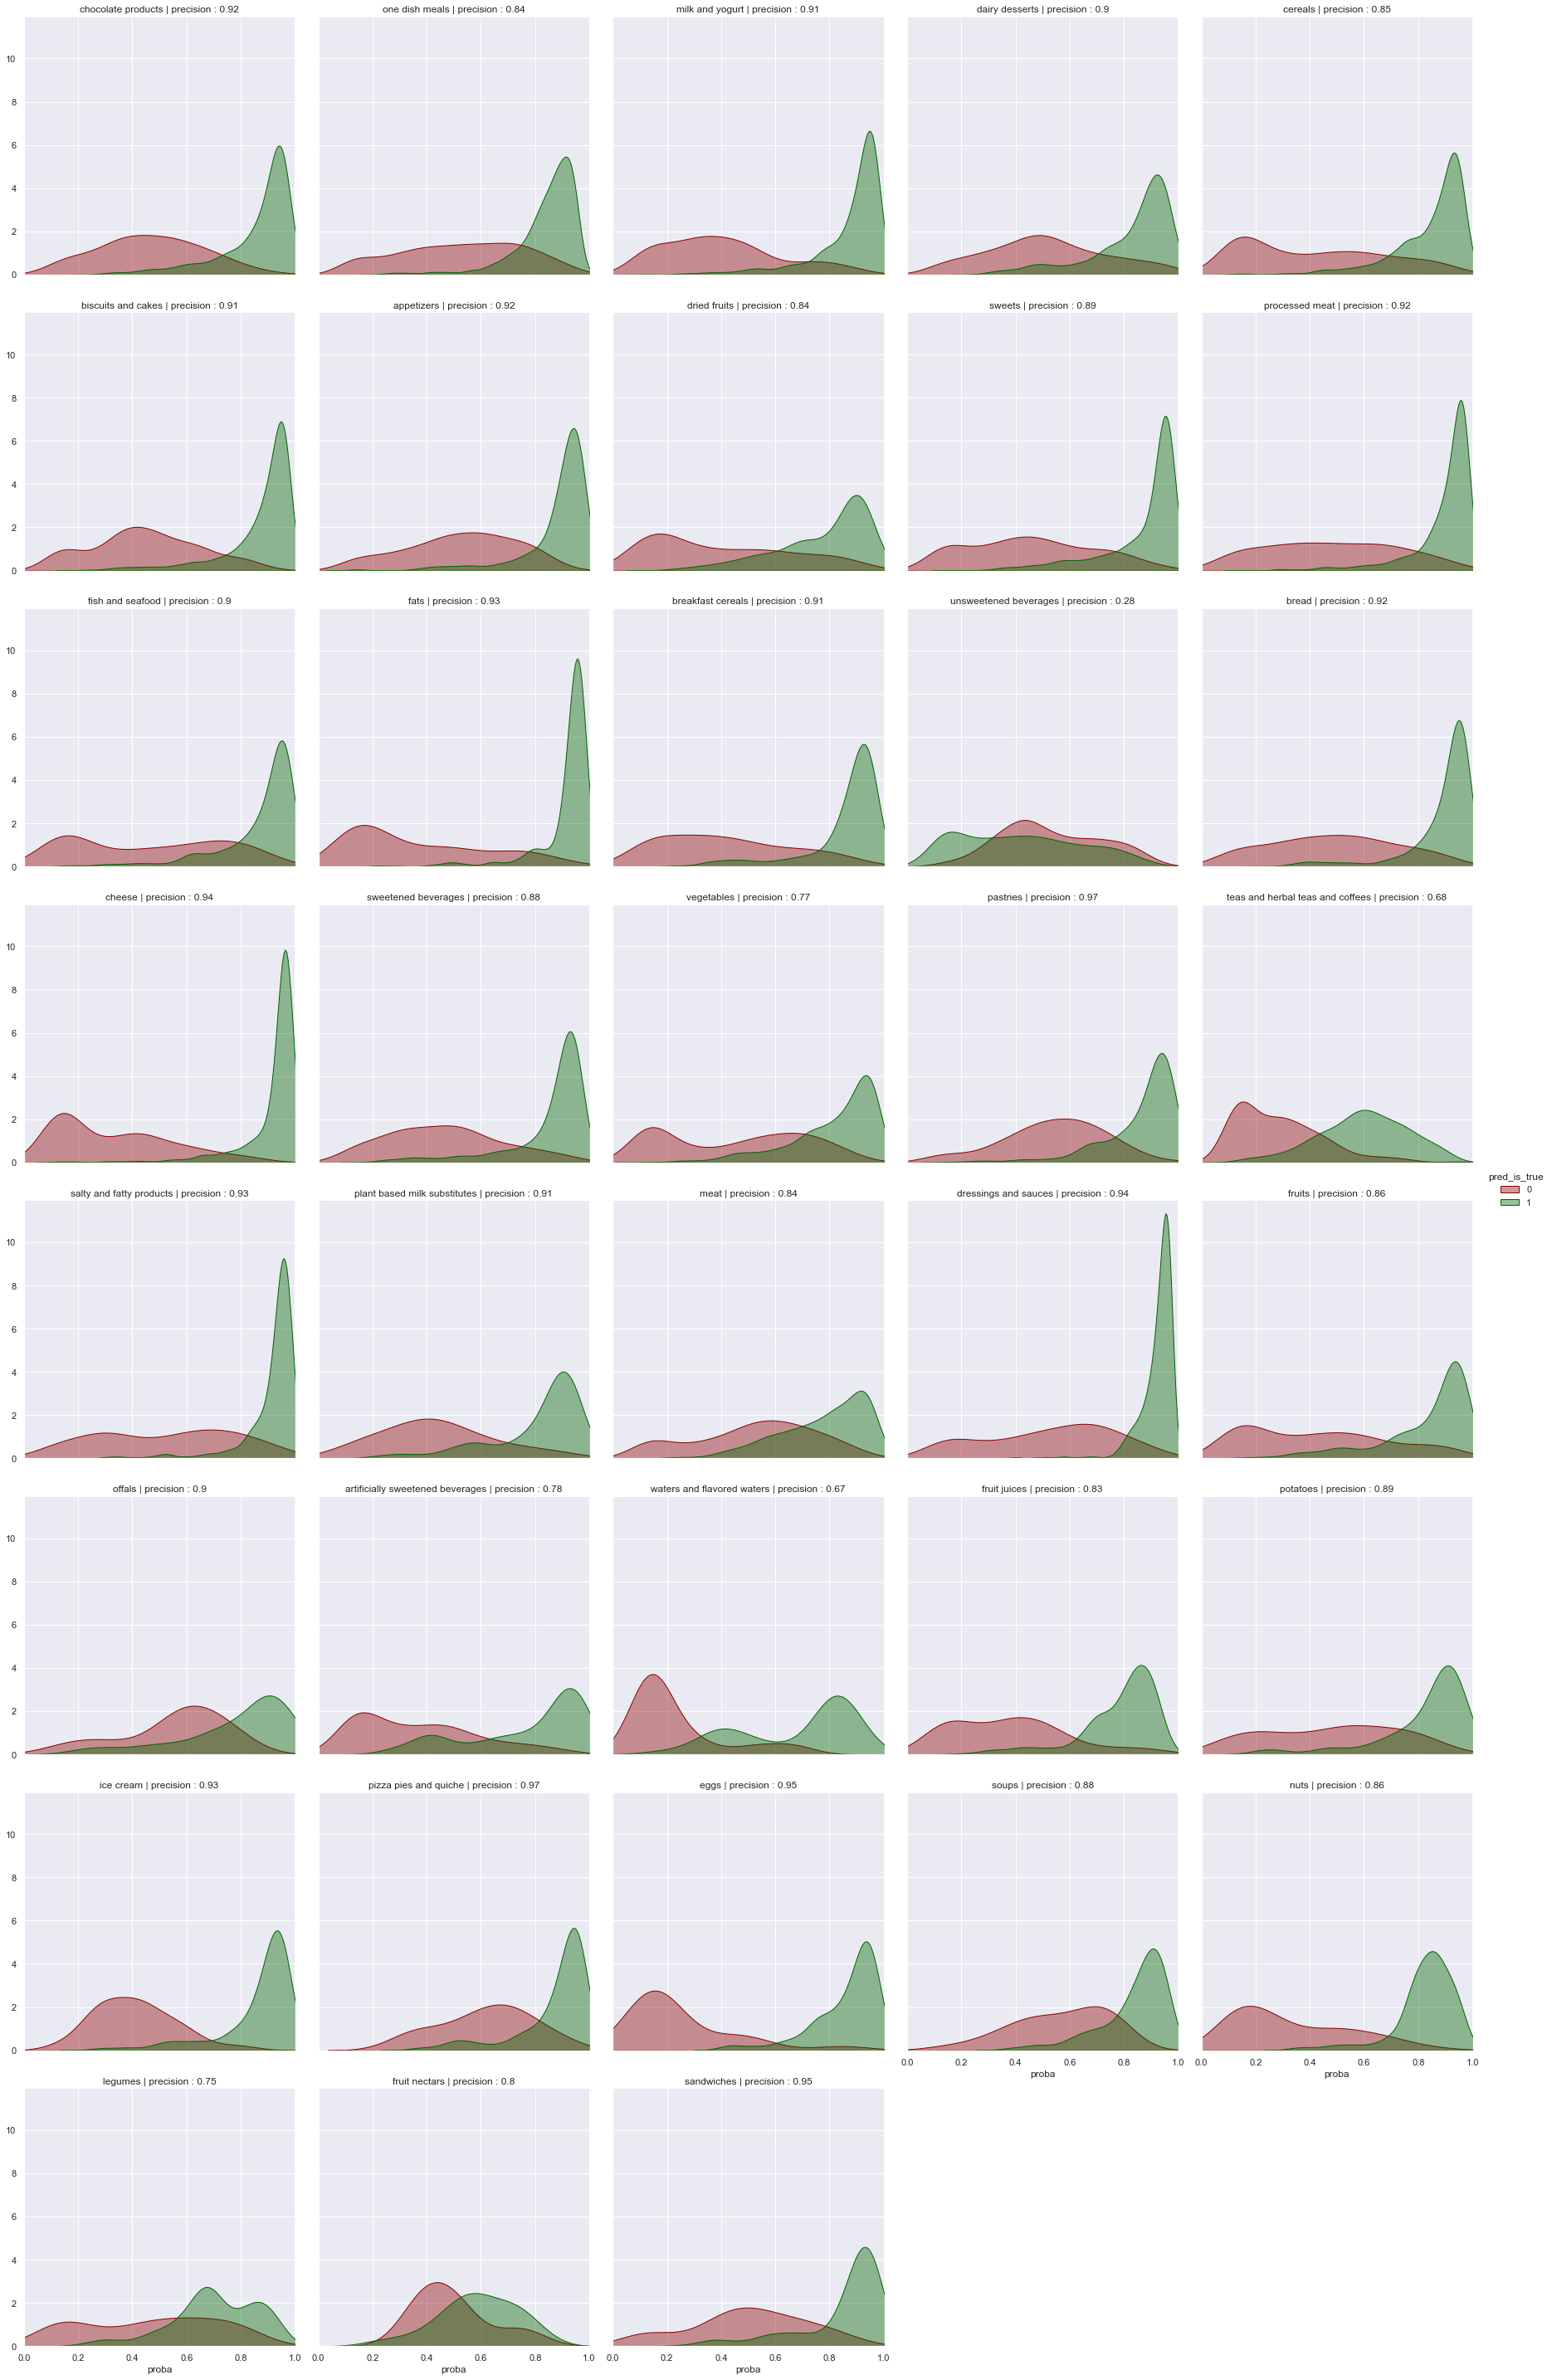

In [96]:
plot_confidence(model=xgb_model_group_2, X=X_test_withpred, y=y_test[:,1], label_encoder=le_2, name='xgboost')

In [122]:
preds_train = xgb_model_group_1.predict(X_train)
X_trainwithpred = np.append(X_train, preds_train.reshape(-1,1), axis=1)
preds_train_2 = xgb_model_group_2.predict(X_trainwithpred)
y_preds_train = np.append(preds_train.reshape(-1,1), preds_train_2.reshape(-1,1), axis=1)
classifier_metrics(y_test=y_train[:,0], y_preds=y_preds_train[:,0], average='macro', model='Train Set Class1 - XGBoost')
classifier_metrics(y_test=y_train[:,1], y_preds=y_preds_train[:,1], average='macro', model='Train Set Class2 - XGBoost')

Train Set Class1 - XGBoost Classification Metrics :
-------------------
Accuracy : 88.82%
Recall : 87.57%
Precision : 88.92%
F1-score : 88.09%


Train Set Class2 - XGBoost Classification Metrics :
-------------------
Accuracy : 85.66%
Recall : 81.68%
Precision : 86.40%
F1-score : 83.57%


